In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)


In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)

        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)

        x = x.view(-1, 16*4*4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------
# Basic Residual Block
# ------------------------------
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut for when dimensions change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# ------------------------------
# ResNet-8 Model
# ------------------------------
class ResNet8(nn.Module):
    def __init__(self, num_classes=10, in_channels=1):  # in_channels=1 for grayscale
        super().__init__()

        # Initial conv layer
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Stages (each stage = one BasicBlock)
        self.layer1 = BasicBlock(16, 16, stride=1)
        self.layer2 = BasicBlock(16, 32, stride=2)
        self.layer3 = BasicBlock(32, 64, stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out


# Example: create model
model = ResNet8(num_classes=10, in_channels=1)
print(model)


ResNet8(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

In [10]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
#model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in tqdm(trainloader, desc="Evaluation"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}")


Evaluation: 100%|██████████| 938/938 [01:34<00:00,  9.89it/s]


Epoch [1/3], Loss: 0.0499


Evaluation: 100%|██████████| 938/938 [01:42<00:00,  9.19it/s]


Epoch [2/3], Loss: 0.0350


Evaluation: 100%|██████████| 938/938 [01:38<00:00,  9.56it/s]

Epoch [3/3], Loss: 0.0281


In [11]:
def test_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

acc = test_accuracy(model, testloader)
print(f"Clean Test Accuracy: {acc:.2f}%")


Clean Test Accuracy: 98.84%


### Adversial Attack

In [12]:
def pgd_attack(model, images, labels,
               epsilon=0.3, alpha=0.01, iters=40,
               random_start=True):

    model.eval()
    images = images.to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()

    # random start inside epsilon-ball
    if random_start:
        noise = torch.empty_like(images).uniform_(-epsilon, epsilon)
        adv_images = torch.clamp(ori_images + noise, 0, 1).detach()
    else:
        adv_images = ori_images.clone().detach()

    for i in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = criterion(outputs, labels)

        model.zero_grad()
        if adv_images.grad is not None:
            adv_images.grad.data.zero_()
        loss.backward()

        # gradient step
        adv_images = adv_images + alpha * adv_images.grad.sign()

        # project into epsilon-ball
        adv_images = torch.max(torch.min(adv_images, ori_images + epsilon), ori_images - epsilon)

        # valid pixel range
        adv_images = torch.clamp(adv_images, 0, 1).detach()

    return adv_images


In [13]:
from tqdm import tqdm

def evaluate_pgd(model, loader, epsilon=0.05, alpha=0.01, iters=40):
    model.eval()
    total = 0
    clean_correct = 0
    adv_correct = 0
    flipped = 0

    for images, labels in tqdm(loader, desc="PGD Evaluation"):
        images, labels = images.to(device), labels.to(device)
        total += labels.size(0)

        # clean predictions
        with torch.no_grad():
            clean_out = model(images)
            _, clean_pred = clean_out.max(1)
            clean_correct += (clean_pred == labels).sum().item()

        # adversarial examples
        adv_images = pgd_attack(model, images, labels,
                                epsilon=epsilon, alpha=alpha, iters=iters)

        with torch.no_grad():
            adv_out = model(adv_images)
            _, adv_pred = adv_out.max(1)
            adv_correct += (adv_pred == labels).sum().item()

        # Attack Success Rate
        flipped += ((clean_pred == labels) & (adv_pred != labels)).sum().item()

    clean_acc = 100 * clean_correct / total
    adv_acc = 100 * adv_correct / total
    asr = flipped / clean_correct

    return clean_acc, adv_acc, asr

In [14]:
clean_acc, adv_acc, asr = evaluate_pgd(model, testloader)
print("Clean Accuracy:", clean_acc)
print("Adversarial Accuracy:", adv_acc)
print("Attack Success Rate (ASR):", asr)

PGD Evaluation: 100%|██████████| 10/10 [10:18<00:00, 61.90s/it]

Clean Accuracy: 98.84
Adversarial Accuracy: 68.69
Attack Success Rate (ASR): 0.30503844597329016


In [11]:
import itertools

epsilons = [0.05, 0.1, 0.2, 0.3]
#alphas   = [0.005, 0.01, 0.02]
iters_list = [20, 40]

configs = list(itertools.product(epsilons, iters_list))


In [12]:
results = []

for eps, iters in configs:
    print(f"\n--- Testing ε={eps}, iters={iters} ---")

    clean_acc, adv_acc, asr = evaluate_pgd(
        model,
        testloader,
        epsilon=eps,
        iters=iters
    )

    results.append({
        "epsilon": eps,
        "iters": iters,
        "clean_acc": clean_acc,
        "adv_acc": adv_acc,
        "asr": asr
    })



--- Testing ε=0.05, iters=20 ---


PGD Evaluation: 100%|██████████| 10/10 [00:50<00:00,  5.07s/it]



--- Testing ε=0.05, iters=40 ---


PGD Evaluation: 100%|██████████| 10/10 [01:34<00:00,  9.47s/it]



--- Testing ε=0.1, iters=20 ---


PGD Evaluation: 100%|██████████| 10/10 [00:47<00:00,  4.79s/it]



--- Testing ε=0.1, iters=40 ---


PGD Evaluation: 100%|██████████| 10/10 [01:33<00:00,  9.36s/it]



--- Testing ε=0.2, iters=20 ---


PGD Evaluation: 100%|██████████| 10/10 [00:49<00:00,  4.96s/it]



--- Testing ε=0.2, iters=40 ---


PGD Evaluation: 100%|██████████| 10/10 [01:34<00:00,  9.42s/it]



--- Testing ε=0.3, iters=20 ---


PGD Evaluation: 100%|██████████| 10/10 [00:50<00:00,  5.05s/it]



--- Testing ε=0.3, iters=40 ---


PGD Evaluation: 100%|██████████| 10/10 [01:35<00:00,  9.57s/it]


In [ ]:
import pandas as pd

df = pd.DataFrame(results)
df.to_csv
print(df)


   epsilon  iters  clean_acc  adv_acc       asr
0     0.05     20      98.57    91.48  0.071929
1     0.05     40      98.57    91.43  0.072436
2     0.10     20      98.57    60.32  0.388049
3     0.10     40      98.57    58.56  0.405904
4     0.20     20      98.57     8.22  0.916607
5     0.20     40      98.57     2.11  0.978594
6     0.30     20      98.57     1.97  0.980014
7     0.30     40      98.57     0.00  1.000000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract directly from your DataFrame
epsilons = df["epsilon"].values
clean_acc = df["clean_acc"].values
adv_acc = df["adv_acc"].values

# Bar positions
x = np.arange(len(epsilons))
width = 0.35

plt.figure(figsize=(8, 5))

# Grouped bars
plt.bar(x - width/2, clean_acc, width, label="Clean Accuracy")
plt.bar(x + width/2, adv_acc, width, label="Adversarial Accuracy")

# Labels + title
plt.xlabel("Epsilon (ε)")
plt.ylabel("Accuracy (%)")
plt.title("Clean vs Adversarial Accuracy Across ε")
plt.xticks(x, epsilons)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


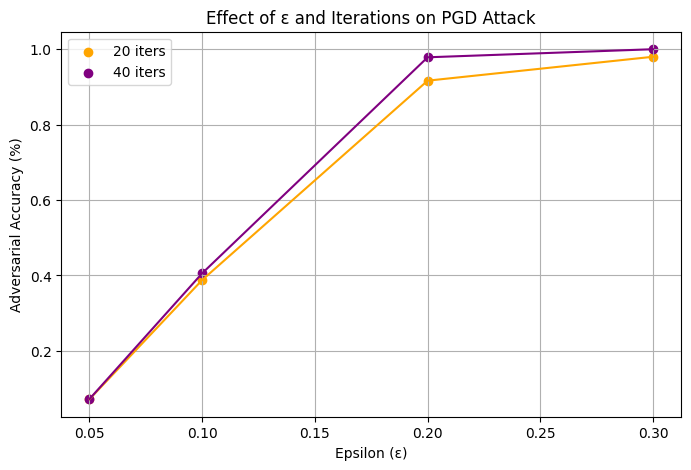

In [16]:
# Separate data by iteration
df_20 = df[df['iters'] == 20]
df_40 = df[df['iters'] == 40]

# Plot
plt.figure(figsize=(8,5))

plt.scatter(df_20['epsilon'], df_20['asr'], color='orange', label='20 iters')
plt.plot(df_20['epsilon'], df_20['asr'], color='orange')

plt.scatter(df_40['epsilon'], df_40['asr'], color='purple', label='40 iters')
plt.plot(df_40['epsilon'], df_40['asr'], color='purple')

plt.xlabel('Epsilon (ε)')
plt.ylabel('Adversarial Accuracy (%)')
plt.title('Effect of ε and Iterations on PGD Attack')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
resnet_df = pd.read_csv("ResNetResults.csv")
lenet_df = pd.read_csv("LeNetResults.csv")

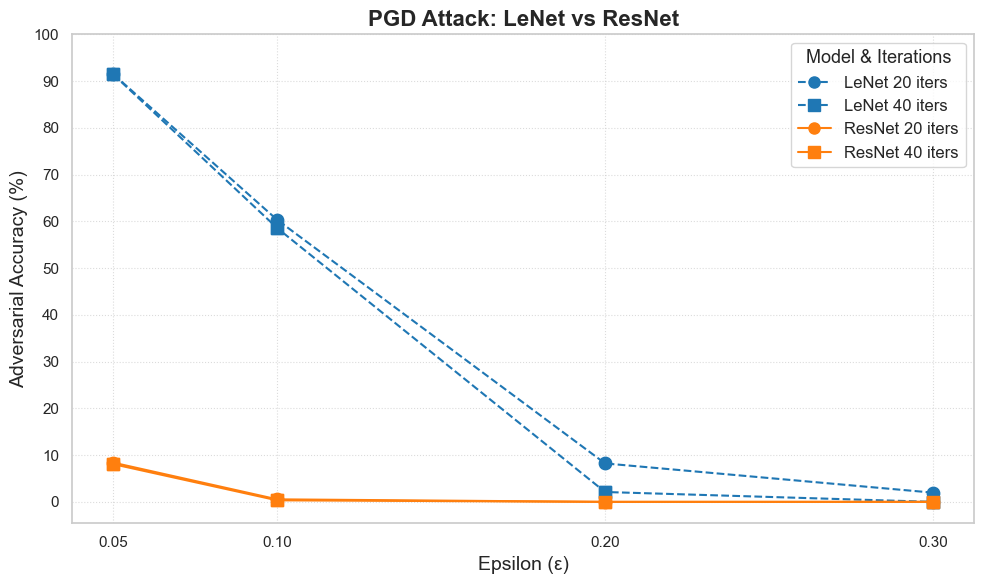

In [20]:
# Color and marker setup (colorblind-friendly)
colors = {'LeNet': '#1f77b4', 'ResNet': '#ff7f0e'}  # blue and orange
markers = {20: 'o', 40: 's'}
linestyles = {'LeNet': '--', 'ResNet': '-'}

plt.figure(figsize=(10,6))

# --- Plot LeNet ---
for iters in [20, 40]:
    subset = lenet_df[lenet_df['iters'] == iters]
    plt.plot(subset['epsilon'], subset['adv_acc'],
             label=f'LeNet {iters} iters',
             color=colors['LeNet'],
             marker=markers[iters],
             linestyle=linestyles['LeNet'],
             markersize=8)
    plt.scatter(subset['epsilon'], subset['adv_acc'],
                color=colors['LeNet'],
                marker=markers[iters],
                s=80)

# --- Plot ResNet ---
for iters in [20, 40]:
    subset = resnet_df[resnet_df['iters'] == iters]
    
    # Avoid plotting duplicate lines for overlapping adv_acc
    # Only plot line if values are different from previous iteration
    if not all(subset['adv_acc'].values == resnet_df[resnet_df['iters']==20]['adv_acc'].values) or iters == 20:
        plt.plot(subset['epsilon'], subset['adv_acc'],
                 label=f'ResNet {iters} iters',
                 color=colors['ResNet'],
                 marker=markers[iters],
                 linestyle=linestyles['ResNet'],
                 markersize=8)
    plt.scatter(subset['epsilon'], subset['adv_acc'],
                color=colors['ResNet'],
                marker=markers[iters],
                s=80)

# Labels and title
plt.xlabel('Epsilon (ε)', fontsize=14)
plt.ylabel('Adversarial Accuracy (%)', fontsize=14)
plt.title('PGD Attack: LeNet vs ResNet', fontsize=16, fontweight='bold')

# Legend
plt.legend(title='Model & Iterations', fontsize=12, title_fontsize=13)

# Ticks and grid
plt.xticks([0.05,0.10,0.20,0.30])
plt.yticks(range(0,101,10))
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)

plt.tight_layout()
plt.show()
